In [23]:
# 📘 Alzheimer's GAN Training Notebook

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt


In [24]:

# --- Configuration ---
image_size = 128
batch_size = 64
z_dim = 100
lr = 0.0002
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_dir = "alz_generated_samples"
os.makedirs(sample_dir, exist_ok=True)


In [25]:

# --- Data Loader ---
transform = transforms.Compose([
    transforms.Grayscale(),  # ensure grayscale format
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize pixel values to [-1, 1]
])

dataset = ImageFolder(root="./data/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [26]:

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, stride=4, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d((8, 8)),  # <--- Ensures fixed size for Linear

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [28]:

# --- Initialize ---
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optim_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [29]:

# --- Track Losses ---
g_losses, d_losses = [], []

# --- Training Loop ---
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --- Train Discriminator ---
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        d_real = discriminator(real_imgs)
        d_fake = discriminator(fake_imgs.detach())

        d_loss_real = criterion(d_real, real_labels)
        d_loss_fake = criterion(d_fake, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

        # --- Train Generator ---
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(dataloader)}] "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Record losses
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Save grid of generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            samples = generator(z)
            grid = make_grid(samples, nrow=8, normalize=True)
            save_image(grid, os.path.join(sample_dir, f"grid_epoch_{epoch+1}.png"))


Epoch [1/100] Batch [0/531] D Loss: 1.3941, G Loss: 0.8837
Epoch [1/100] Batch [50/531] D Loss: 0.0112, G Loss: 5.8085
Epoch [1/100] Batch [100/531] D Loss: 0.0082, G Loss: 6.3505
Epoch [1/100] Batch [150/531] D Loss: 0.0827, G Loss: 4.9781
Epoch [1/100] Batch [200/531] D Loss: 0.2572, G Loss: 3.9397
Epoch [1/100] Batch [250/531] D Loss: 0.4407, G Loss: 2.3315
Epoch [1/100] Batch [300/531] D Loss: 0.9450, G Loss: 1.2487
Epoch [1/100] Batch [350/531] D Loss: 0.9712, G Loss: 0.3727
Epoch [1/100] Batch [400/531] D Loss: 0.4532, G Loss: 2.7639
Epoch [1/100] Batch [450/531] D Loss: 0.5187, G Loss: 1.5995
Epoch [1/100] Batch [500/531] D Loss: 1.4051, G Loss: 6.0488
Epoch [2/100] Batch [0/531] D Loss: 0.8775, G Loss: 5.0019
Epoch [2/100] Batch [50/531] D Loss: 0.6444, G Loss: 5.4015
Epoch [2/100] Batch [100/531] D Loss: 0.4429, G Loss: 2.2640
Epoch [2/100] Batch [150/531] D Loss: 0.3419, G Loss: 2.3480
Epoch [2/100] Batch [200/531] D Loss: 0.4990, G Loss: 2.6003
Epoch [2/100] Batch [250/531] 

In [30]:

# Save generator
torch.save(generator.state_dict(), "alz_gan_generator.pth")
print("✅ Generator model saved!")


✅ Generator model saved!


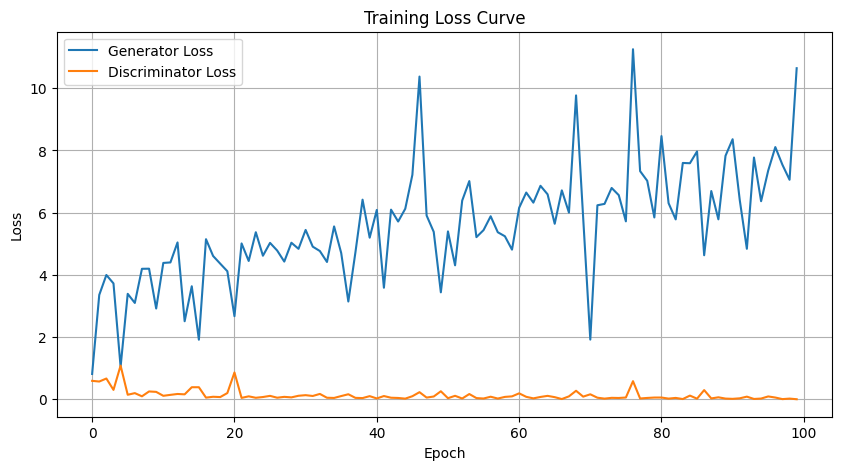

In [31]:

# --- Loss Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


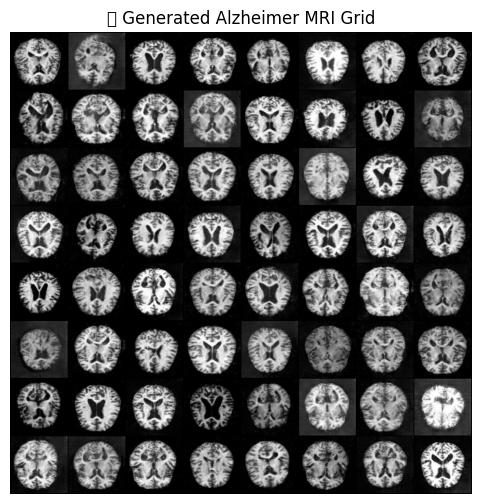

C:\Users\molim\AppData\Local\Temp\ipykernel_10188\653207835.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='Set2')
C:\Users\molim\AppData\Local\Temp\ipykernel_10188\653207835.py:75: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


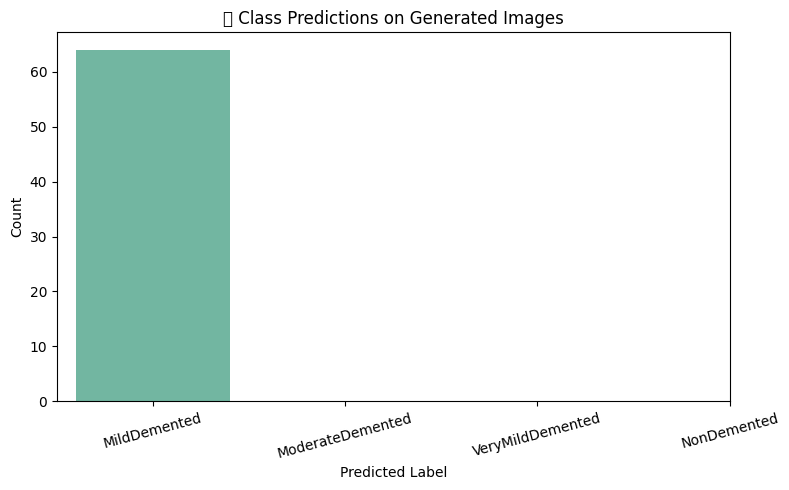

🧠 Patch-wise Predictions:
Patch 01: MildDemented
Patch 02: MildDemented
Patch 03: MildDemented
Patch 04: MildDemented
Patch 05: MildDemented
Patch 06: MildDemented
Patch 07: MildDemented
Patch 08: MildDemented
Patch 09: MildDemented
Patch 10: MildDemented
Patch 11: MildDemented
Patch 12: MildDemented
Patch 13: MildDemented
Patch 14: MildDemented
Patch 15: MildDemented
Patch 16: MildDemented
Patch 17: MildDemented
Patch 18: MildDemented
Patch 19: MildDemented
Patch 20: MildDemented
Patch 21: MildDemented
Patch 22: MildDemented
Patch 23: MildDemented
Patch 24: MildDemented
Patch 25: MildDemented
Patch 26: MildDemented
Patch 27: MildDemented
Patch 28: MildDemented
Patch 29: MildDemented
Patch 30: MildDemented
Patch 31: MildDemented
Patch 32: MildDemented
Patch 33: MildDemented
Patch 34: MildDemented
Patch 35: MildDemented
Patch 36: MildDemented
Patch 37: MildDemented
Patch 38: MildDemented
Patch 39: MildDemented
Patch 40: MildDemented
Patch 41: MildDemented
Patch 42: MildDemented
Patch 43

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Define CNN Classifier
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ----------------------------
# Split Grid Image into 1x128x128 Tensors
# ----------------------------
def split_grid_to_images(grid_path, img_size=128):
    grid_img = Image.open(grid_path).convert("L")
    grid_arr = np.array(grid_img)

    imgs = []
    n_rows = grid_arr.shape[0] // img_size
    n_cols = grid_arr.shape[1] // img_size

    for i in range(n_rows):
        for j in range(n_cols):
            crop = grid_arr[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size]
            crop_img = torch.tensor(crop / 255.0).float().unsqueeze(0).unsqueeze(0)  # 1x1x128x128
            imgs.append(crop_img)
    return torch.cat(imgs, dim=0), grid_img

# ----------------------------
# Evaluation + Visualization
# ----------------------------
def evaluate_generated_grid(grid_path, model, class_names):
    model.eval()
    images, raw_grid = split_grid_to_images(grid_path)
    images = images.to(device)

    preds = model(images)
    probs = F.softmax(preds, dim=1)
    labels = torch.argmax(probs, dim=1).cpu().numpy()

    #  Plot the generated image grid
    plt.figure(figsize=(6, 6))
    plt.title("🧬 Generated Alzheimer MRI Grid")
    plt.axis('off')
    plt.imshow(raw_grid, cmap='gray')
    plt.show()

    #  Plot prediction distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x=labels, palette='Set2')
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=15)
    plt.title(" Class Predictions on Generated Images")
    plt.ylabel("Count")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    #  Print patch-wise predictions
    print(" Patch-wise Predictions:")
    for i, label in enumerate(labels):
        print(f"Patch {i+1:02d}: {class_names[label]}")

# ----------------------------
# Usage (After Epoch 100 or every 10 epochs)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = SimpleCNN(num_classes=4).to(device)

# Optional: Load pre-trained weights
# cnn.load_state_dict(torch.load("alz_cnn_classifier.pth"))

class_names = ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']
grid_image_path = "alz_generated_samples/grid_epoch_90.png"
evaluate_generated_grid(grid_image_path, cnn, class_names)
